# Analysis of Movie Critics, Their Opinions, and What Makes a Good Movie?

**Report Author:** Angad Kalra  
**SN:** 1005134999  
**Summary:** Analysis on NYT movie critics, movies they've reviewed, and characteristics of movies affecting revenue.

## Introduction

#### The purpose of this report is to answer three questions:
1. How accurate are current NYT movie critics when it comes to predicting box office hits?
2. Do the critic's movie reviews align with whether the movie was a critic's pick?
3. What characteristics are unique among movies that perform well financially?

#### Due to limited API requests, only recent movies and reviews were considered. 

## Methods

**Q1:**  
1. For each critic, their most recent picks were gathered from NYT API; for each pick, the box office total was requested from TMDB API. 
2. The accuracy of a critic is the ratio between the number of critic picks with box office totals greater than $100  million and the total number of of movies reviewed.  

**Q2:**  
1. For each critic, sentiment analysis was performed on their recent movie reviews (scraped from NYT website) resulting in a value between -1 and 1 (sentiment polarity).  
2. Each review was plotted on a 2 dimensional plot with their x-coordinate being sentiment polarity and y-coordinate being 1 or 0, depending on if the movie was a critic's pick or not. 
3. A logistic regresssion model was applied to the data and the prediction score was evaluated.    

**Q3:**  
1. Retrieve all movies, using TMDB API, released between January 2010 and January 2017 and sort them by descending revenue.  
2. Movies ranked 1st - 100th are put into one dataset (top100), and movies ranked 200th - 300th are put into another dataset (bottom100).
3. Movie characteristics compared were **budget, genre frequency, and release season.**  
4. To compare budget, a side-by-side boxplot was used.  
5. To compare release season, compare the season counts for each dataset.  
6. To compare genres, count the frequency of each genre in each dataset and rank them in descending order. 

In [71]:
# Setup code
import numpy as np
import pandas as pd
import requests, json, os, sys, time 
import matplotlib.pyplot as plt
from sklearn import linear_model

# Sample data collection code

# API urls & keys
nyt_url = "http://api.nytimes.com/svc/movies/v2"
nyt_apikey = "72aaefb1f009451e986a0e446468f649"

tmdb_url = "https://api.themoviedb.org/3"
tmdb_apikey = "49200255c3dc5d6af15e04656ea5f7c4"

# List of critics
url = nyt_url + "/critics/full-time.json"
critics_res = requests.get(url, params={"api-key": nyt_apikey})
if critics_res.status_code == 200:
    critics_res = json.loads(critics_res.text)
    critics = [x["display_name"] for x in critics_res["results"]]
else:
    print(json.loads(critics_res.text))

# List of genres
genres_url = tmdb_url + "/genre/movie/list"
genres_resp = requests.get(genres_url, params={"api_key": tmdb_apikey})
if genres_resp.status_code == 200:
    genres = json.loads(genres_resp.text)
    genres = [x["name"] for x in genres["genres"]]
else:
    print(json.loads(genres_resp.text))

## Results

### Q1

In [ ]:
# Table of movies + financial outcome
url = nyt_url + "/reviews/search.json"
critics_list = []
movie_titles = []
box_office_total = []

def get_bo_total(c, i):
    resp = requests.get(url, params={"api-key": nyt_apikey, "critics-pick": "Y", "reviewer": c,
                                            "offset": int(i*20)})
    
    if resp.status_code == 200:
        resp = json.loads(resp.text)
    else:
        print(json.loads(resp.text))

    results = resp["results"]

    for r in results:
        tmdb_resp = requests.get(tmdb_url + "/search/movie", 
                            params={"api_key": tmdb_apikey, "query": r["display_title"], 
                                    "primary_release_year": int(r["publication_date"][0:4]) })
        
        if tmdb_resp.status_code == 200:
            tmdb_resp = json.loads(tmdb_resp.text)

            if (tmdb_resp["total_results"] > 0):
                mid = tmdb_resp["results"][0]["id"]
                movie_info = requests.get(tmdb_url + "/movie/{}".format(mid), params={"api_key": tmdb_apikey})
                
                if movie_info.status_code == 200:
                    movie_info = json.loads(movie_info.text)

                    if (movie_info["revenue"] > 0):
                        critics_list.append(c)
                        movie_titles.append(movie_info["title"])
                        box_office_total.append(movie_info["revenue"])
        elif tmdb_resp.status_code == 429:
            time.sleep(12)
            
            tmdb_resp = requests.get(tmdb_url + "/search/movie", 
                            params={"api_key": tmdb_apikey, "query": r["display_title"], 
                                    "primary_release_year": int(r["publication_date"][0:4]) })
            
            tmdb_resp = json.loads(tmdb_resp.text)

            if (tmdb_resp["total_results"] > 0):
                mid = tmdb_resp["results"][0]["id"]
                movie_info = requests.get(tmdb_url + "/movie/{}".format(mid), params={"api_key": tmdb_apikey})
                
                if movie_info.status_code == 200:
                    movie_info = json.loads(movie_info.text)

                    if (movie_info["revenue"] > 0):
                        critics_list.append(c)
                        movie_titles.append(movie_info["title"])
                        box_office_total.append(movie_info["revenue"])
            
                
# Get critic pick movies for each critic + info and create dataframe.
for c in critics:
    for i in range(0, 5):
        get_bo_total(c, i)
        
# Create DataFrame from critics, movies, box office revenue. 
df_dict = {"critic": pd.Series(critics_list, dtype=str), "movie_title": pd.Series(movie_titles, dtype=str), 
                        "box_office_total": pd.Series(box_office_total, dtype=np.int64)}
q1_df = pd.DataFrame(df_dict)

# Save data to csv
q1_df.to_csv(path_or_buf="q1_df.csv")

In [6]:
# Load q1_df from csv
q1_df = pd.read_csv("q1_df.csv")

# Analyze Critic BOH Prediction Accuracy
box_office_hit = 60000000

for c in critics:
    c_movies = q1_df.loc[q1_df["critic"] == c]
    num_movies = c_movies.shape[0]
    num_hits = c_movies.loc[c_movies["box_office_total"] >= box_office_hit].shape[0]
    accuracy = num_hits/num_movies
    
    print("Critic: {0}, # of Picks: {2}, Accuracy: {1}\n".format(c, accuracy, num_movies))

Critic: A. O. Scott, # of Picks: 51, Accuracy: 0.35294117647058826

Critic: Manohla Dargis, # of Picks: 55, Accuracy: 0.34545454545454546

Critic: Stephen Holden, # of Picks: 26, Accuracy: 0.038461538461538464



* A. O. Scott and Manohla Dargis have the highest accuracies out of the three critics, around 35%. 
* Overall, the three critics shown here are not accurate at predicitng box office hits.

### Q2

In [95]:
# Table of movies + review sentiment
from bs4 import BeautifulSoup
from textblob import TextBlob

url = nyt_url + "/reviews/search.json"
critics_list = []
movie_titles = []
movie_reviews = []
review_sentiment = []
critic_pick = []

def get_movie_reviews(c, i):
    resp = requests.get(url, params={"api-key": nyt_apikey, "reviewer": c, "offset": int(i*20)})
    
    if resp.status_code == 200:
        resp = json.loads(resp.text)
    else:
        print(json.loads(resp.text))
        
    results = resp["results"]
    
    # For each review by critic, get the review using url
    for r in results:
        review_url = r["link"]["url"]
        resp = requests.get(review_url)
        
        if resp.status_code == 200:
            resp = resp.text
            soup = BeautifulSoup(resp, 'html.parser')
            article = soup.find('section', attrs={'name': "articleBody"})
            paragraphs = article.find_all('p', class_="css-1xl4flh e2kc3sl0")
            
            if (len(paragraphs) > 0):
                review = []
                
                for p in paragraphs:
                    review.append(p.text)
                
                review = "".join(review)
                movie_reviews.append(review)
                review = TextBlob(review)
                
                critics_list.append(c)
                review_sentiment.append(review.sentiment.polarity)
                movie_titles.append(r["display_title"])
                critic_pick.append(r["critics_pick"])

for c in critics:
    for i in range(0,3):
        get_movie_reviews(c,i)
    
# Create DataFrame from movies, review sentiment and critic's pick. 
df_dict = {"critic": pd.Series(critics_list, dtype=str), "movie_title": pd.Series(movie_titles, dtype=str), 
               "review_sentiment": pd.Series(review_sentiment, dtype=np.float16), 
                   "critic_pick": pd.Series(critic_pick, dtype=np.bool)}

q2_df = pd.DataFrame(df_dict)

# Save q2_df to file
q2_df.to_csv(path_or_buf="q2_df.csv")

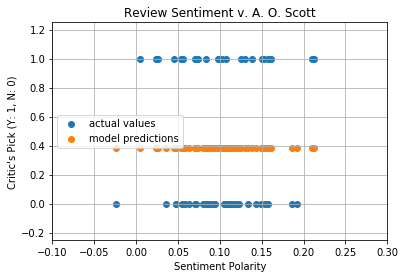

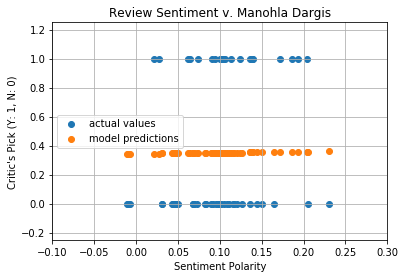

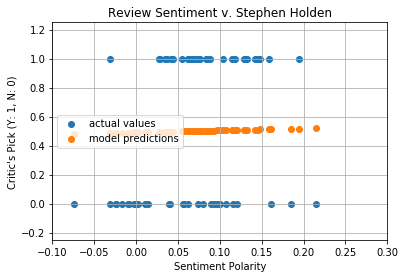

In [106]:
# Load q2_df from csv
q2_df = pd.read_csv("q2_df.csv")
q2_df = q2_df.drop('Unnamed: 0', axis=1)

# Analyze Critic Pick vs Sentiment Analysis

model = linear_model.LogisticRegression(solver='lbfgs')

for index, c in enumerate(critics):
    plt.figure(index+1)
    
    critic_df = q2_df.loc[q2_df["critic"] == c]
    x_vals = critic_df["review_sentiment"].values.reshape(-1,1)
    y_vals = np.array([int(x) for x in critic_df["critic_pick"]])
    clf = model.fit(x_vals, y_vals)
    y_pred = model.predict_proba(x_vals)
    
    plt.scatter(x_vals, y_vals, label="actual values")
    plt.scatter(x_vals, y_pred[:,1], label="model predictions") 
    plt.axis([-0.1, 0.30, -0.25, 1.25])
    plt.xlabel("Sentiment Polarity")
    plt.ylabel("Critic's Pick (Y: 1, N: 0)")
    plt.title("Review Sentiment v. {}".format(c))
    plt.legend(loc=6)
    plt.grid(True)
    
    plt.show()

    

In [121]:
# % of positive reviews that are 1 and % of negative reviews that are 0
for c in critics:
    critic_df = q2_df.loc[q2_df["critic"] == c]
    cdf_pos = critic_df.loc[critic_df["review_sentiment"] > 0]["critic_pick"].sum(axis=0)/critic_df.shape[0]
    cdf_neg = critic_df.loc[critic_df["review_sentiment"] < 0]["critic_pick"].sum(axis=0)/critic_df.shape[0]
    print("Critic: {}, % of pos. CPs: {:.3f}, % of neg. CPs: {:.3f}".format(c, cdf_pos, cdf_neg))

Critic: A. O. Scott, % of pos. CPs: 0.383, % of neg. CPs: 0.000
Critic: Manohla Dargis, % of pos. CPs: 0.350, % of neg. CPs: 0.000
Critic: Stephen Holden, % of pos. CPs: 0.483, % of neg. CPs: 0.017


* There does not seem to be a clear relationship between review sentiment and being a critic's pick.
* Movies with negative sentiment were almost never a critic's pick. 
* Movies with positive sentiment had mix between being selected as CP and not being selected.

### Q3

In [ ]:
# Top 100 revenue movie characteristics

top100_url = tmdb_url + "/discover/movie"
top100_movies = []

def handle_resp(resp):
    resp = json.loads(resp.text)
    results = resp["results"]

    for r in results:
        mid = r["id"]
        movie_info = requests.get(tmdb_url + "/movie/{}".format(mid), 
                                params={"api_key": tmdb_apikey})

        if movie_info.status_code == 200:
            movie_info = json.loads(movie_info.text)
            top100_movies.append({"budget": movie_info["budget"], "genres": movie_info["genres"], 
                                  "release_date": movie_info["release_date"],
                                    "revenue": movie_info["revenue"], "title": movie_info["title"]} )
        else:
            print(json.loads(movie_info.text))
            continue

for i in range(1,6):
    resp = requests.get(top100_url, params={"api_key": tmdb_apikey, "sort_by": "revenue.desc", "page": i,
                                           "primary_release_date.gte": "2010-01-01", 
                                            "primary_release_data.lte": "2017-01-01"})
    if (resp.status_code == 200):
        handle_resp(resp) 
    elif resp.status_code == 429:
        time.sleep(13)
        resp = requests.get(top100_url, params={"api_key": tmdb_apikey, "sort_by": "revenue.desc", "page": i,
                                           "primary_release_date.gte": "2010-01-01", 
                                            "primary_release_data.lte": "2017-01-01"})
        handle_resp(resp)
    else:
        print(json.loads(resp.text))


In [24]:
# Create top 100 movies DataFrame
top100_cols = ["title", "budget", "release_season"]
top100_cols.extend(genres)
top100_cols.append("revenue")

df_dict = {}
for key in top100_cols:
    df_dict[key] = []

for g in genres:
    df_dict[g] = [0]*len(top100_movies)
    
for ind, movie in enumerate(top100_movies):
    df_dict["budget"].append(movie["budget"])
    df_dict["title"].append(movie["title"])
    df_dict["revenue"].append(movie["revenue"])
    
    movie_genres = [x["name"] for x in movie["genres"]]
    
    for g in movie_genres:
        df_dict[g][ind] = 1
        
    release_month = int(movie["release_date"].split("-")[1])
    
    if release_month in [1, 2, 12]:
        df_dict["release_season"] = "Winter"
    elif release_month in [3, 4, 5]:
        df_dict["release_season"] = "Spring"
    elif release_month in [6, 7, 8]:
        df_dict["release_season"] = "Summer"
    else:
        df_dict["release_season"] = "Fall"

top100_df = pd.DataFrame.from_dict(df_dict)

# Save top100_df to csv
top100_df.to_csv(path_or_buf="top100_df.csv")

In [ ]:
# Bottom 100 revenue movie characteristics

bottom100_url = tmdb_url + "/discover/movie"
bottom100_movies = []

# buffer between top100 movies code running
time.sleep(11)

def handle_resp(resp):
    resp = json.loads(resp.text)
    results = resp["results"]

    for r in results:
        mid = r["id"]
        movie_info = requests.get(tmdb_url + "/movie/{}".format(mid), 
                                params={"api_key": tmdb_apikey})

        if movie_info.status_code == 200:
            movie_info = json.loads(movie_info.text)
            bottom100_movies.append({"budget": movie_info["budget"], "genres": movie_info["genres"], 
                                  "release_date": movie_info["release_date"],
                                    "revenue": movie_info["revenue"], "title": movie_info["title"]} )
        else:
            print(json.loads(movie_info.text))
            continue 

for i in range(10,16):
    resp = requests.get(bottom100_url, params={"api_key": tmdb_apikey, "sort_by": "revenue.desc", "page": i,
                                           "primary_release_date.gte": "2010-01-01", 
                                            "primary_release_data.lte": "2017-01-01"})
    if (resp.status_code == 200):
        handle_resp(resp)
    elif resp.status_code == 429:
        time.sleep(13)
        resp = requests.get(bottom100_url, params={"api_key": tmdb_apikey, "sort_by": "revenue.desc", "page": i,
                                           "primary_release_date.gte": "2010-01-01", 
                                            "primary_release_data.lte": "2017-01-01"})
        handle_resp(resp)
    else:
        json.loads(resp.text)



In [27]:
# Create bottom 100 movies DataFrame
bottom100_cols = ["title", "budget", "release_season"]
bottom100_cols.extend(genres)
bottom100_cols.append("revenue")

df_dict = {}
for key in bottom100_cols:
    df_dict[key] = []

for g in genres:
    df_dict[g] = [0]*len(bottom100_movies)
    
for ind, movie in enumerate(bottom100_movies):
    df_dict["budget"].append(movie["budget"])
    df_dict["title"].append(movie["title"])
    df_dict["revenue"].append(movie["revenue"])
    
    movie_genres = [x["name"] for x in movie["genres"]]
    for g in movie_genres:
        df_dict[g][ind] = 1
        
    release_month = int(movie["release_date"].split("-")[1])
    
    if release_month in [1, 2, 12]:
        df_dict["release_season"] = "Winter"
    elif release_month in [3, 4, 5]:
        df_dict["release_season"] = "Spring"
    elif release_month in [6, 7, 8]:
        df_dict["release_season"] = "Summer"
    else:
        df_dict["release_season"] = "Fall"

bottom100_df = pd.DataFrame.from_dict(df_dict)

# Save data to file
bottom100_df.to_csv(path_or_buf="bottom100_df.csv")

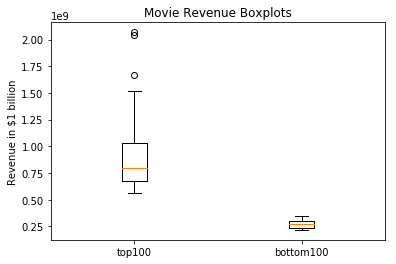

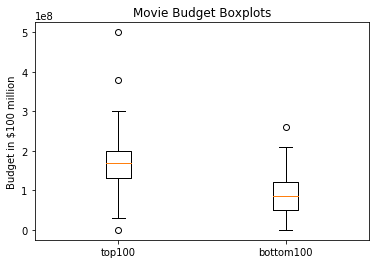

In [109]:
# Revenue boxplots
top100_rev = top100_df["revenue"].values
bot100_rev = bottom100_df["revenue"].values

plt.boxplot([top100_rev, bot100_rev], labels=["top100", "bottom100"])
plt.title("Movie Revenue Boxplots")
plt.ylabel("Revenue in $1 billion")
plt.show()

# Budget boxplots
top100_budget = top100_df["budget"].values
bot100_budget = bottom100_df["budget"].values

plt.boxplot([top100_budget, bot100_budget], labels=["top100", "bottom100"])
plt.title("Movie Budget Boxplots")
plt.ylabel("Budget in $100 million")
plt.show()



* The revenues between the top100 and bottom100 movies are vastly different.
* However, their budgets are closer in value. The top100 movies do have higher budgets on average.

In [130]:
# Release Season Histogram
top100_relseason_counts = top100_df["release_season"].value_counts()
bott100_relseason_counts = bottom100_df["release_season"].value_counts()

print(top100_relseason_counts)
print(bott100_relseason_counts)

Summer    98
Name: release_season, dtype: int64
Summer    119
Name: release_season, dtype: int64


* Movies in both categories were always released during the summer months (J, J, A)

In [51]:
# Genre Analysis
top100_genres = top100_df.iloc[:,3:21]
bott100_genres = bottom100_df.iloc[:, 3:21]

top100_genres_sum = top100_genres.sum(axis=0)
top100_genres_sum = top100_genres_sum.sort_values(ascending=False)

bott100_genres_sum = bott100_genres.sum(axis=0)
bott100_genres_sum = bott100_genres_sum.sort_values(ascending=False)

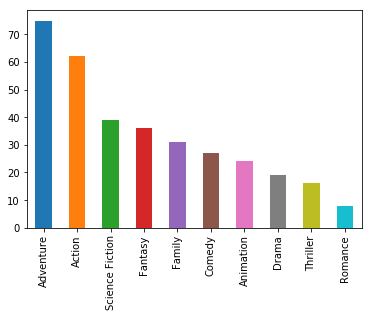

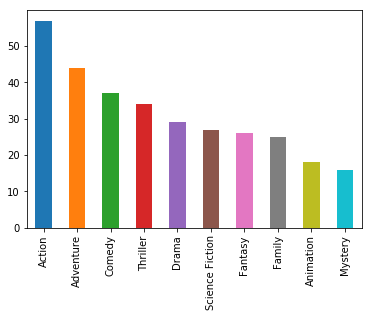

In [112]:
plt.figure(1)
top100_genres_sum[:10].plot.bar()

plt.figure(2)
bott100_genres_sum[:10].plot.bar()

* Top100 movies have more movies in Adventure, Action, Sci-Fi, Fantasy, Family. 
* Bottom100 has more Comedy, Thriller, Drama.

## Conclusion

**Q1:**  
* **Result Summary:** 
    * All three critics had accuracies well below 50%, with the highest being 35% and lowest being 4%.
* **Limitations:**
    * The API from which revenue was retrieved had a limit on the number of requests per 10 seconds. 
    * The box office hit benchmark was arbitrary and chosen by me. 
* **Future Considerations:**
    * Using more sophisticated API requests, retrieve more movie reviews per critic to get better accuracy measure. 
    * Analyze historical box office data to get more accurate benchmark of a box office hit. 

**Q2:**  
* **Result Summary:** 
    * Negative review sentiment did not result in CP but positive review sentiment did not clearly indicate CP. 
* **Limitations:**
    * Sentiment Analysis package used was simple and for beginners. 
* **Future Considerations:**
    * Use different sentiment analysis packages and compare results.
    * Get more reviews for each critic.


**Q3:**  
* **Result Summary:** 
    * Movies with higher budgets are associated with higher revenues.
    * Movies released in the summer months are associated with higher revenues.
    * Movies containing Action, Adventure, Sci-Fi, Fantasy, and Family genres are associated with higher revenue. 
* **Limitations:**
    * The API from which revenue was retrieved had a limit on the number of requests per 10 seconds. 
    * Retrieving more indepth movie details from free APIs. 
* **Future Considerations:**
    * Using more sophisticated API requests, retrieve more movies for both datasets. 
    * Include other influential movie characteristics such as director, main actors, movie language, part of sequel/trilogy/series, production companies.  